# Testing production and degradation on ABC

In [3]:
import pints
import pints.toy as toy
import pints.toy.stochastic
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

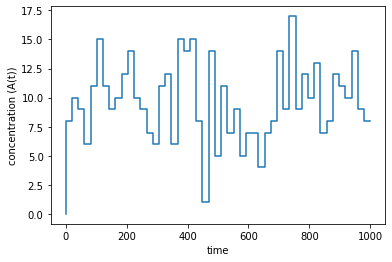

In [4]:
np.random.seed(7)

# Load a forward model
n_0 = 0
model = toy.stochastic.ProductionDegradationModel(n_0)

# Create some toy data
k = [0.1, 1]
times = np.linspace(0, 1000, 50)

values = model.simulate(k, times)
# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)
# Create a uniform prior parameter
log_prior = pints.UniformLogPrior([0.0, 0.5], [0.3, 2])
# Set the error measure to be used to compare simulated to observed data
error_measure = pints.RootMeanSquaredError(problem)
plt.step(times, values)


plt.xlabel('time')
plt.ylabel('concentration (A(t))')
plt.show()

# Calculating the posterior

In [5]:
import math

# Single stationary distribution
def s_stationary(theta, n):
    fct = math.factorial(n)
    frac = theta[1] / theta[0]
    return (frac ** n) * np.exp(-frac) / fct

def p_stationary(theta, data):
    prod = 1.0
    for d in data:
        prod *= s_stationary(theta, d[0])
    return prod

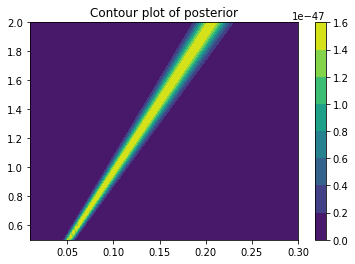

In [6]:
xlist = np.linspace(0.01, 0.3, 100)
ylist = np.linspace(0.5, 2, 100)
X, Y = np.meshgrid(xlist, ylist)
Z = [[p_stationary([x, y], values[10:]) for x in xlist] for y in ylist]
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp)
ax.set_title('Contour plot of posterior')
plt.show()

# Compute integral

In [7]:
from scipy import integrate

def f(x, y):
    return p_stationary([x, y], values[10:])

def bounds_x(y):
    return [0.0, 0.3]

def bounds_y():
    return [0.5, 2]

res = integrate.nquad(f, [bounds_x, bounds_y])

print("integral is ="+str(res))

def normalized_posterior(x, y):
    return p_stationary([x, y], values[10:]) / res[0]

new_approx = integrate.nquad(normalized_posterior, [bounds_x, bounds_y])

print("new integral should be 1="+str(new_approx))


integral is =(3.9473804110212486e-49, 5.696996805929298e-49)
new integral should be 1=(0.9982564874830195, 1.1142026796040793e-08)


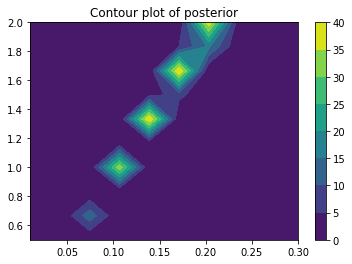

In [8]:
xlist = np.linspace(0.01, 0.3, 10)
ylist = np.linspace(0.5, 2, 10)
X, Y = np.meshgrid(xlist, ylist)
Z = [[normalized_posterior(x, y) for x in xlist] for y in ylist]
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp)
ax.set_title('Contour plot of posterior')
plt.show()

# Compute marginal distributions

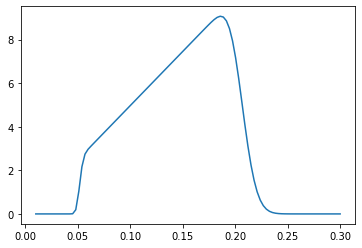

In [9]:
def marginal_distribution_x(x):
    partial_lam = lambda y : normalized_posterior(x, y)
    return integrate.quad(partial_lam, 0.5, 2)[0]

thetas = np.linspace(0.01, 0.3, 100)

results = []
for theta in thetas:
    results.append(marginal_distribution_x(theta))

plt.plot(thetas, results)
plt.show()

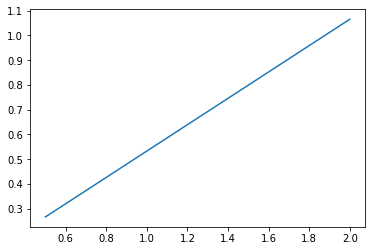

In [10]:
def marginal_distribution_y(y):
    partial_lam = lambda x : normalized_posterior(x, y)
    return integrate.quad(partial_lam, 0, 0.3)[0]

thetas = np.linspace(0.5, 2, 100)

results = []
for theta in thetas:
    results.append(marginal_distribution_y(theta))

plt.plot(thetas, results)
plt.show()

# Rejection ABC

In [9]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate


error_thresholds = [10, 8, 6, 5]
resulting_kl = []

for error in error_thresholds:
    abc = pints.ABCController(error_measure, log_prior)
    # set threshold
    abc.sampler().set_threshold(error)
    # set target number of samples
    abc.set_n_samples(1000)
    # log to screen
    abc.set_log_to_screen(True)
    print('Running...')
    samples  = abc.run()
    print('Done')

    samples_flat = np.array([item for sublist in samples for item in sublist])

    # computing the KDE and KL functions for x

    def marginal_distribution_x(x):
        partial_lam = lambda y : normalized_posterior(x, y)
        return integrate.quad(partial_lam, 0.5, 2)[0]

    def kl_func_x(y, kde_skl):
        part = marginal_distribution_x(y)
        s_part = np.exp(kde_skl.score_samples([[y]]))
        if s_part == 0 or part == 0:
            print("something with = "+str(y))
            print("")
            return -np.inf
        else:
            saved = part * np.log(part / s_part)
            return saved

    def kl_div_x(x, bandwidth, **kwargs):
        kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
        kde_skl.fit(x[:, np.newaxis])
        fun = lambda y : kl_func_x(y, kde_skl)
        return integrate.quad(fun, 0.013, 0.3)

    saved_x = kl_div_x(samples_flat[:, 0], 0.07)[0]

    # computing the KDE and KL functions for x
    def marginal_distribution_y(y):
        partial_lam = lambda x : normalized_posterior(x, y)
        return integrate.quad(partial_lam, 0, 0.3)[0]

    def kl_func_y(y, kde_skl):
        part = marginal_distribution_y(y)
        s_part = np.exp(kde_skl.score_samples([[y]]))
        if s_part == 0 or part == 0:
            print("something with = "+str(y))
            print("")
            return -np.inf
        else:
            saved = part * np.log(part / s_part)
            return saved
    
    def kl_div_y(x, bandwidth, **kwargs):
        kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
        kde_skl.fit(x[:, np.newaxis])
        fun = lambda y : kl_func_y(y, kde_skl)
        return integrate.quad(fun, 0.5, 2)

    saved_y = kl_div_y(samples_flat[:, 1], 0.1)[0]
    saved = saved_x + saved_y
    resulting_kl.append(saved)

    print("saved_x="+str(saved_x)+", saved_y="+str(saved_y))

Running...
Using Rejection ABC
Running in sequential mode.
Iter. Eval. Acceptance rate Time m:s
1     1      1                0:00.1
2     2      1                0:00.2
3     5      0.6              0:00.3
20    31     0.64516129       0:01.5
40    65     0.615384615      0:03.7
60    90     0.666666667      0:05.0
80    119    0.672268907563   0:06.4
100   146    0.684931507      0:07.7
120   175    0.685714286      0:09.0
140   198    0.707070707      0:10.1
160   220    0.727272727      0:11.4
180   246    0.731707317      0:12.8
200   273    0.732600733      0:14.0
220   299    0.735785953      0:15.4
240   328    0.731707317      0:16.9
260   351    0.740740741      0:18.2
280   375    0.746666667      0:19.6
300   398    0.753768844      0:20.8
320   425    0.752941176      0:22.3
340   450    0.755555556      0:23.4
360   478    0.753138075      0:24.9
380   501    0.758483034      0:26.0
400   526    0.760456274      0:27.1
420   552    0.760869565      0:28.4
440   583    0.7

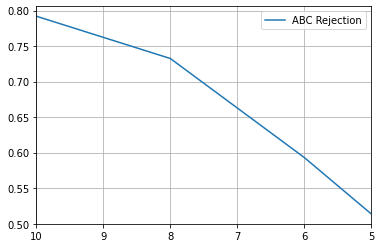

In [10]:
res_rej_abc = resulting_kl

fig, ax = plt.subplots()

ax.plot(error_thresholds, res_rej_abc, label='ABC Rejection')
ax.set_xlim(10, 5)
ax.grid(True)
ax.legend()

# import os

# __file = r"C:\Users\Victor\Desktop\disertation_2022\experiments\degradation"

# my_path = os.path.abspath(__file)


# plt.savefig(my_path + '/degradation_errors_adaptive.pdf')
plt.show()

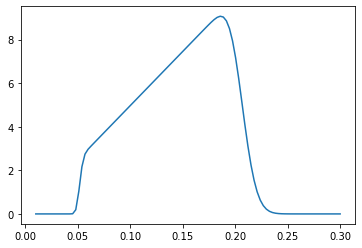

In [11]:
def marginal_distribution_x(x):
    partial_lam = lambda y : normalized_posterior(x, y)
    return integrate.quad(partial_lam, 0.5, 2)[0]

thetas_x = np.linspace(0.01, 0.3, 100)

results_x = []
for theta in thetas_x:
    results_x.append(marginal_distribution_x(theta))

plt.plot(thetas_x, results_x)
plt.show()

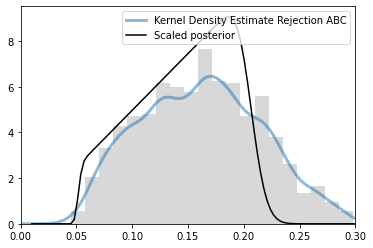

finished computing kde + 0.4497880641799385


In [12]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate


# Margin x
fig, ax = plt.subplots(1, 1, sharey=True)
t_samples = np.array([x for y in samples[:, 0] for x in y])

# Computing integral
kde_skl = KernelDensity(bandwidth=0.2)

part_samples = samples_flat[:, 0]
kde_skl.fit(part_samples[:, np.newaxis])


def test_func(x):
    arr = np.array([x])
    res = kde_skl.score_samples(arr[:, np.newaxis])
    return np.exp(res)
    

int_val = integrate.quad(test_func, 0, 0.3)[0]


def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_sk = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_sk.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_sk.score_samples(x_grid[:, np.newaxis])

    return np.exp(log_pdf) / int_val

x_grid = np.linspace(0, 0.3, 100)

ax.plot(x_grid, kde_sklearn(t_samples, x_grid, bandwidth=0.01),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)


ax.hist(samples_flat[:, 0], 20, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
plt.plot(thetas_x, results_x, color='black', label='Scaled posterior')
ax.set_xlim(0, 0.3)
ax.legend(loc='upper right')
plt.show()

# Compute KL divergence
def kl_func_x(y, kde_skl):
    part = marginal_distribution_x(y)
    s_part = np.exp(kde_skl.score_samples([[y]]))
    if s_part == 0 or part == 0:
        print("something with = "+str(y))
        print("")
        return -np.inf
    else:
        # print("part="+str(part))
        # print("s_part="+str(s_part))
        saved = part * np.log(part / s_part)
        return saved

def kl_div(x, bandwidth, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    fun = lambda y : kl_func_x(y, kde_skl)
    return integrate.quad(fun, 0.013, 0.3)
    
t_samples = np.array([x for x in samples[:, 0]])
saved = kl_div(samples_flat[:, 0], 0.07)[0]
print("finished computing kde + "+str(saved))

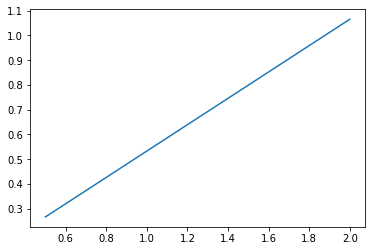

In [13]:
def marginal_distribution_y(y):
    partial_lam = lambda x : normalized_posterior(x, y)
    return integrate.quad(partial_lam, 0, 0.3)[0]

thetas = np.linspace(0.5, 2, 100)

norm_term = integrate.quad(marginal_distribution_y, 0.5, 2)

results_y = []
for theta in thetas:
    results_y.append(marginal_distribution_y(theta))

plt.plot(thetas, results_y)
plt.show()

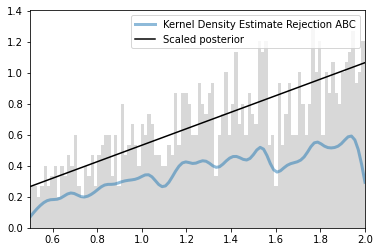

finished computing kde + 0.06394514198282594


In [14]:
# Margin x
fig, ax = plt.subplots(1, 1, sharey=True)
t_samples = np.array([x for y in samples[:, 0] for x in y])

# Computing integral
kde_skl = KernelDensity(bandwidth=0.2)

part_samples = samples_flat[:, 1]
kde_skl.fit(part_samples[:, np.newaxis])


def test_func(x):
    arr = np.array([x])
    res = kde_skl.score_samples(arr[:, np.newaxis])
    return np.exp(res)
    

int_val = integrate.quad(test_func, 0.5, 2)[0]


def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    kde_sk = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_sk.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_sk.score_samples(x_grid[:, np.newaxis])

    return np.exp(log_pdf) / int_val

x_grid = np.linspace(0.5, 2, 100)

ax.plot(x_grid, kde_sklearn(t_samples, x_grid, bandwidth=0.03),
            label='Kernel Density Estimate Rejection ABC', linewidth=3, alpha=0.5)

ax.hist(samples_flat[:, 1], 100, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
plt.plot(thetas, results_y, color='black', label='Scaled posterior')
ax.set_xlim(0.5, 2)
ax.legend(loc='upper right')
plt.show()


def marginal_distribution_y(y):
        partial_lam = lambda x : normalized_posterior(x, y)
        return integrate.quad(partial_lam, 0, 0.3)[0]

def kl_func_y(y, kde_skl):
    part = marginal_distribution_y(y)
    s_part = np.exp(kde_skl.score_samples([[y]]))
    if s_part == 0 or part == 0:
        print("something with = "+str(y))
        print("")
        return -np.inf
    else:
        saved = part * np.log(part / s_part)
        return saved

def kl_div_y(x, bandwidth, **kwargs):
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    fun = lambda y : kl_func_y(y, kde_skl)
    return integrate.quad(fun, 0.5, 2)


t_samples = np.array([x for x in samples[:, 0]])
saved = kl_div_y(samples_flat[:, 1], 0.1)[0]
print("finished computing kde + "+str(saved))

# Modified PMC

In [15]:
error_thresholds = [10, 8, 6, 5]
resulting_kl = []

for error in error_thresholds:
    
    np.random.seed(0)
    abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)
    # set initial threshold
    abc.sampler().set_threshold_schedule(np.array([1.5 * error, 1.3 * error, error]))

    # produce intermediate distributions of size 200
    abc.sampler().set_intermediate_size(200)

    # set target number of samples
    abc.set_n_samples(1000)

    # log to screen
    abc.set_log_to_screen(True)

    samples = abc.run()
    print("Done")

    samples_flat = np.array([item for item in samples])

    # computing the KDE and KL functions for x
    def marginal_distribution_x(x):
        partial_lam = lambda y : normalized_posterior(x, y)
        return integrate.quad(partial_lam, 0.5, 2)[0]

    def kl_func_x(y, kde_skl):
        part = marginal_distribution_x(y)
        s_part = np.exp(kde_skl.score_samples([[y]]))
        if s_part == 0 or part == 0:
            print("something with = "+str(y))
            print("")
            return -np.inf
        else:
            saved = part * np.log(part / s_part)
            return saved

    def kl_div_x(x, bandwidth, **kwargs):
        kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
        kde_skl.fit(x[:, np.newaxis])
        fun = lambda y : kl_func_x(y, kde_skl)
        return integrate.quad(fun, 0.013, 0.3)

    saved_x = kl_div_x(samples_flat[:, 0], 0.07)[0]

    # computing the KDE and KL functions for x
    def marginal_distribution_y(y):
        partial_lam = lambda x : normalized_posterior(x, y)
        return integrate.quad(partial_lam, 0, 0.3)[0]

    def kl_func_y(y, kde_skl):
        part = marginal_distribution_y(y)
        s_part = np.exp(kde_skl.score_samples([[y]]))
        if s_part == 0 or part == 0:
            print("something with = "+str(y))
            print("")
            return -np.inf
        else:
            saved = part * np.log(part / s_part)
            return saved
    
    def kl_div_y(x, bandwidth, **kwargs):
        kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
        kde_skl.fit(x[:, np.newaxis])
        fun = lambda y : kl_func_y(y, kde_skl)
        return integrate.quad(fun, 0.5, 2)

    saved_y = kl_div_y(samples_flat[:, 1], 0.1)[0]
    saved = saved_x + saved_y
    resulting_kl.append(saved)

    print("saved_x="+str(saved_x)+", saved_y="+str(saved_y))

Using ABC-SMC
Running in sequential mode.
Trying t=1, threshold=13.0
Trying t=2, threshold=10.0
Iter. Eval. Acceptance rate Time m:s
1     460    0.00217391304    0:18.9
2     461    0.00433839479    0:18.9
3     462    0.00649350649    0:19.0
20    480    0.0416666667     0:19.6
40    503    0.0795228628     0:20.7
60    524    0.114503817      0:21.5
80    545    0.146788991      0:22.3
100   567    0.176366843      0:23.2
120   589    0.203735144      0:24.0
140   611    0.22913257       0:24.7
160   631    0.253565769      0:25.5
180   654    0.275229358      0:26.5
200   674    0.296735905      0:27.3
220   696    0.316091954023   0:28.0
240   718    0.334261838      0:28.9
260   739    0.351826793      0:29.7
280   762    0.367454068      0:30.7
300   785    0.382165605      0:31.6
320   805    0.397515528      0:32.4
340   827    0.411124547      0:33.1
360   849    0.424028269      0:34.1
380   872    0.435779817      0:35.0
400   892    0.448430493      0:35.8
420   913    0.4

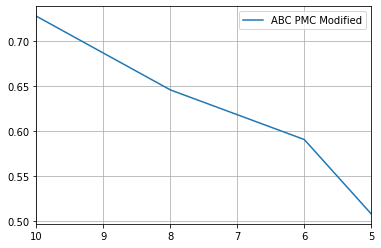

In [16]:
res_fake_pmc = resulting_kl

fig, ax = plt.subplots()

ax.plot(error_thresholds, res_fake_pmc, label='ABC PMC Modified')
ax.set_xlim(10, 5)
ax.grid(True)
ax.legend()

# import os

# __file = r"C:\Users\Victor\Desktop\disertation_2022\experiments\degradation"

# my_path = os.path.abspath(__file)


# plt.savefig(my_path + '/degradation_errors_adaptive.pdf')


# ABC PMC

In [17]:
error_thresholds = [10, 8, 6, 5]
resulting_kl = []

for error in error_thresholds:
    
    np.random.seed(2)
    abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)
    # set initial threshold
    abc.sampler().set_threshold_schedule(np.array([1.5 * error, 1.3 * error, error]))

    # produce intermediate distributions of size 200
    abc.sampler().set_intermediate_size(1000)

    # set target number of samples
    abc.set_n_samples(1000)

    # log to screen
    abc.set_log_to_screen(True)

    samples = abc.run()
    print("Done")

    samples_flat = np.array([item for item in samples])


    # computing the KDE and KL functions for x
    def marginal_distribution_x(x):
        partial_lam = lambda y : normalized_posterior(x, y)
        return integrate.quad(partial_lam, 0.5, 2)[0]

    def kl_func_x(y, kde_skl):
        part = marginal_distribution_x(y)
        s_part = np.exp(kde_skl.score_samples([[y]]))
        if s_part == 0 or part == 0:
            print("something with = "+str(y))
            print("")
            return -np.inf
        else:
            saved = part * np.log(part / s_part)
            return saved

    def kl_div_x(x, bandwidth, **kwargs):
        kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
        kde_skl.fit(x[:, np.newaxis])
        fun = lambda y : kl_func_x(y, kde_skl)
        return integrate.quad(fun, 0.013, 0.3)

    saved_x = kl_div_x(samples_flat[:, 0], 0.07)[0]

    # computing the KDE and KL functions for x
    def marginal_distribution_y(y):
        partial_lam = lambda x : normalized_posterior(x, y)
        return integrate.quad(partial_lam, 0, 0.3)[0]

    def kl_func_y(y, kde_skl):
        part = marginal_distribution_y(y)
        s_part = np.exp(kde_skl.score_samples([[y]]))
        if s_part == 0 or part == 0:
            print("something with = "+str(y))
            print("")
            return -np.inf
        else:
            saved = part * np.log(part / s_part)
            return saved
    
    def kl_div_y(x, bandwidth, **kwargs):
        kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
        kde_skl.fit(x[:, np.newaxis])
        fun = lambda y : kl_func_y(y, kde_skl)
        return integrate.quad(fun, 0.5, 2)

    saved_y = kl_div_y(samples_flat[:, 1], 0.1)[0]
    saved = saved_x + saved_y
    resulting_kl.append(saved)

    print("saved_x="+str(saved_x)+", saved_y="+str(saved_y))

Using ABC-SMC
Running in sequential mode.
Trying t=1, threshold=13.0
Trying t=2, threshold=10.0
Iter. Eval. Acceptance rate Time m:s
1     2293   0.0004361099     1:48.5
2     2294   0.000871839582   1:48.5
3     2295   0.00130718954    1:48.6
20    2314   0.00864304235    1:49.3
40    2337   0.0171159606     1:50.2
60    2360   0.0254237288     1:51.1
80    2380   0.0336134454     1:51.8
100   2402   0.0416319734     1:52.6
120   2423   0.0495253818     1:53.4
140   2449   0.0571661903     1:54.5
160   2473   0.0646987465     1:55.4
180   2494   0.0721732157     1:56.2
200   2518   0.0794281176     1:56.9
220   2538   0.0866824271     1:57.7
240   2561   0.0937133932     1:58.5
260   2582   0.100697134      1:59.2
280   2603   0.107568191      1:59.9
300   2623   0.114372855509   2:00.6
320   2644   0.121028744      2:01.4
340   2664   0.127627628      2:02.2
360   2685   0.134078212      2:03.1
380   2707   0.140376801      2:04.0
400   2728   0.146627566      2:04.8
420   2751   0.1

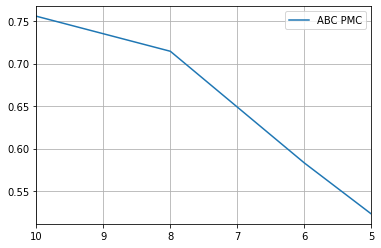

In [18]:
res_true_pmc = resulting_kl

fig, ax = plt.subplots()

ax.plot(error_thresholds, res_true_pmc, label='ABC PMC')
ax.set_xlim(10, 5)
ax.grid(True)
ax.legend()

# import os

# __file = r"C:\Users\Victor\Desktop\disertation_2022\experiments\degradation"

# my_path = os.path.abspath(__file)


# plt.savefig(my_path + '/degradation_errors_adaptive.pdf')

# All errors

[0.7279671925068255, 0.6459892842095734, 0.5907803637138013, 0.5079935375670638]


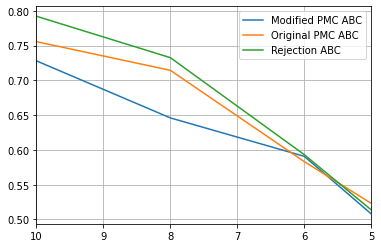

In [22]:
fig, ax = plt.subplots()

print(res_fake_pmc)

ax.plot(error_thresholds, res_fake_pmc, label='Modified PMC ABC')
ax.plot(error_thresholds, res_true_pmc, label='Original PMC ABC')
ax.plot(error_thresholds, res_rej_abc, label='Rejection ABC')
ax.set_xlim(10, 5)
ax.grid(True)
ax.legend()
# plt.show()

import os
__file = r"C:\Users\Victor\Desktop\disertation_2022\experiments\production_degradation"
my_path = os.path.abspath(__file)

plt.savefig(my_path + '/production_degradation_errors_all.pdf')

# Adaptive PMC ABC

In [22]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate

error_thresholds = [0.4, 0.3, 0.2, 0.15]
resulting_kl = []

for error in error_thresholds:
    np.random.seed(2)
    abc = pints.ABCController(error_measure, log_prior, method=pints.ABCAdaptivePMC)

    # set threshold
    abc.sampler().set_N_l(300)

    # set p_acc_min
    abc.sampler().set_p_acc_min(error)

    # set target number of samples
    abc.set_n_samples(1000)

    # log to screen
    abc.set_log_to_screen(True)

    print('Running...')
    samples  = abc.run()
    print('Done')

    samples_flat = np.array([item for item in samples])

    # computing the KDE and KL functions for x
    def marginal_distribution_x(x):
        partial_lam = lambda y : normalized_posterior(x, y)
        return integrate.quad(partial_lam, 0.5, 2)[0]

    def kl_func_x(y, kde_skl):
        part = marginal_distribution_x(y)
        s_part = np.exp(kde_skl.score_samples([[y]]))
        if s_part == 0 or part == 0:
            print("something with = "+str(y))
            print("")
            return -np.inf
        else:
            saved = part * np.log(part / s_part)
            return saved

    def kl_div_x(x, bandwidth, **kwargs):
        kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
        kde_skl.fit(x[:, np.newaxis])
        fun = lambda y : kl_func_x(y, kde_skl)
        return integrate.quad(fun, 0.013, 0.3)

    saved_x = kl_div_x(samples_flat[:, 0], 0.07)[0]

    # computing the KDE and KL functions for x
    def marginal_distribution_y(y):
        partial_lam = lambda x : normalized_posterior(x, y)
        return integrate.quad(partial_lam, 0, 0.3)[0]

    def kl_func_y(y, kde_skl):
        part = marginal_distribution_y(y)
        s_part = np.exp(kde_skl.score_samples([[y]]))
        if s_part == 0 or part == 0:
            print("something with = "+str(y))
            print("")
            return -np.inf
        else:
            saved = part * np.log(part / s_part)
            return saved
    
    def kl_div_y(x, bandwidth, **kwargs):
        kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
        kde_skl.fit(x[:, np.newaxis])
        fun = lambda y : kl_func_y(y, kde_skl)
        return integrate.quad(fun, 0.5, 2)

    saved_y = kl_div_y(samples_flat[:, 1], 0.1)[0]
    saved = saved_x + saved_y
    resulting_kl.append(saved)

    print("saved_x="+str(saved_x)+", saved_y="+str(saved_y))

Running...
Using ABC-Adaptive-PMC
Running in sequential mode.
w_mean=[0.16696646 1.35700351]
resulting var=[[0.007628   0.04027081]
 [0.04027081 0.32539127]]
epsilon=4.675467891024383
w_mean=[0.15410093 1.35620793]
resulting var=[[0.00584344 0.04090864]
 [0.04090864 0.35424711]]
Iter. Eval. Acceptance rate Time m:s
1     3      334              2:47.8
Halting: target number of samples (1002) reached.
Done
saved_x=0.44938302465028057, saved_y=0.0988673247483364
Running...
Using ABC-Adaptive-PMC
Running in sequential mode.
w_mean=[0.16696646 1.35700351]
resulting var=[[0.007628   0.04027081]
 [0.04027081 0.32539127]]
epsilon=4.675467891024383
w_mean=[0.15410093 1.35620793]
resulting var=[[0.00584344 0.04090864]
 [0.04090864 0.35424711]]
epsilon=4.424929377967517
w_mean=[0.15214956 1.37402521]
resulting var=[[0.004874   0.03728172]
 [0.03728172 0.34657223]]
Iter. Eval. Acceptance rate Time m:s
1     4      250.25           3:48.0
Halting: target number of samples (1001) reached.
Done
save

In [23]:
res_adaptive = resulting_kl

No handles with labels found to put in legend.


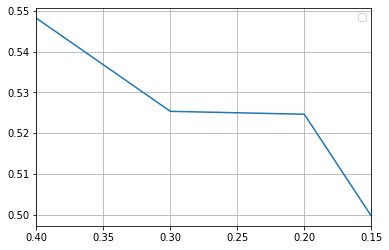

In [26]:
fig, ax = plt.subplots()

ax.plot(error_thresholds, res_adaptive)
# ax.plot(error_thresholds, res_true_pmc, label='Original PMC ABC')
# ax.plot(error_thresholds, res_rej_abc, label='Rejection ABC')
ax.set_xlim(0.4, 0.15)
ax.grid(True)
ax.legend()
# plt.show()

import os
__file = r"C:\Users\Victor\Desktop\disertation_2022\experiments\production_degradation"
my_path = os.path.abspath(__file)

plt.savefig(my_path + '/production_degradation_errors_adaptive.pdf')